In [830]:
signal_period = 12
long_period = 26
trend_period = 200
atr_period = 14
commission_percentage = 0.00001
stop_loss_multiplier = 2
amount_invested = 1000
leverage = 1

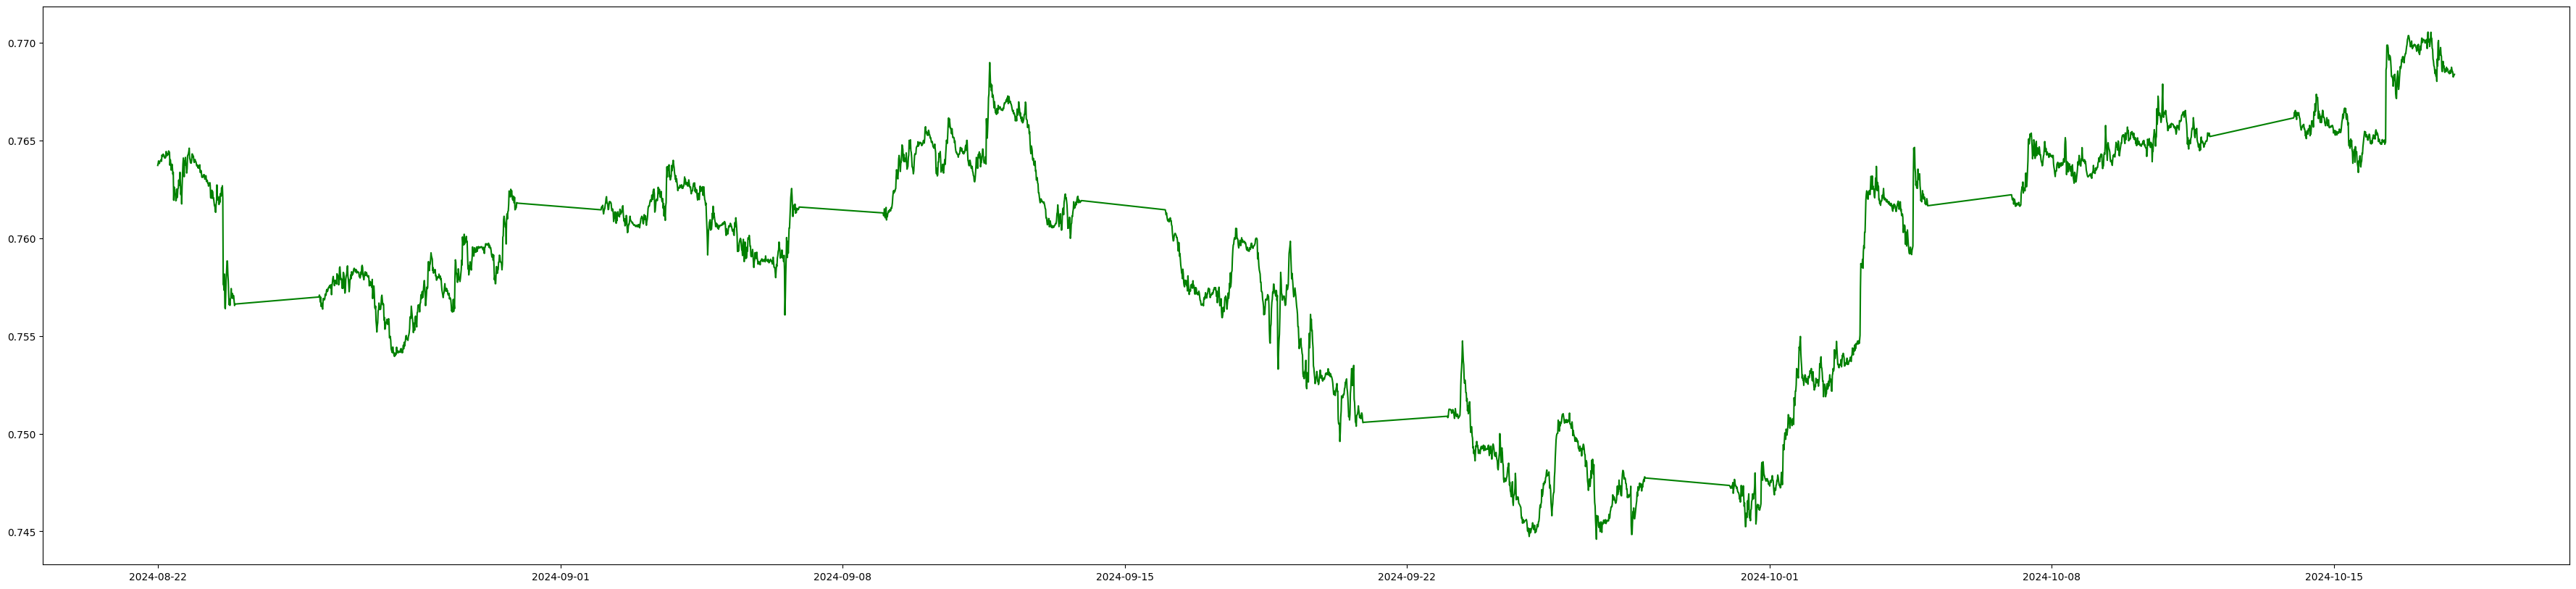

In [831]:
import matplotlib.pyplot as plt
import talib as ta
from datetime import datetime, timedelta
from historical_data.alpaca import AlpacaHistoricalData
from alpaca.data.timeframe import TimeFrameUnit
from historical_data.yfinance import HistoricalData

ticker = 'GBP=X'
asset_type = 'Forex'
start_date = '2024-08-22'
end_date = '2024-10-18'
interval = 15
unit = TimeFrameUnit.Minute

if asset_type == 'Forex':
    forex_data = HistoricalData(ticker, start=start_date, end=end_date, interval='15m')    
    data = forex_data.get_data()
    forex_data.plot_data()
else:
    alpaca_data = AlpacaHistoricalData(ticker, assetType=asset_type, start=start_date, end=end_date, interval=interval, unit=unit)
    data = alpaca_data.get_data()
    alpaca_data.plot_data()

In [832]:
from backtester.strategy import Strategy

class EMACrossoverLongStrategy(Strategy):
    def __init__(self, data):
        super().__init__(data)
        self.data['Trend EMA'] = ta.EMA(self.data['Close'], trend_period)
        self.data['Signal EMA'] = ta.EMA(self.data['Close'], signal_period)
        self.data['Long EMA'] = ta.EMA(self.data['Close'], long_period)
        self.data['Previous Signal EMA'] = data['Signal EMA'].shift()
        self.data['RSI'] = ta.RSI(self.data['Close'], atr_period)
        self.data['ATR'] = ta.ATR(self.data['High'], self.data['Low'], self.data['Close'], atr_period) # ATR is used for setting stop loss
        self.data = self.data.dropna()
             
    def implement(self):
        self.data['Signal'] = 0

        for i in self.data.index:
            if self.position == 'Close':        
                if data.at[i, 'Signal EMA'] >= self.data.at[i, 'Long EMA'] \
                    and data.at[i, 'Previous Signal EMA'] < self.data.at[i, 'Long EMA'] \
                    and data.at[i, 'Close'] >= self.data.at[i, 'Trend EMA']:
                    buy_price =  data.at[i, 'Close']
                    stop_loss = buy_price - (stop_loss_multiplier * self.data.at[i, 'ATR'])
                    take_profit = buy_price + (4 * stop_loss_multiplier * self.data.at[i, 'ATR'])
                    self.position = 'Buy'
                    self.buy_trade(i, stop_loss=stop_loss, take_profit=take_profit)
                    self.data.at[i, 'Signal'] = 1
                    self.count = 0
            else:            
                if self.data.at[i, 'Close'] >= self.take_profit or self.data.at[i, 'Close'] <= self.stop_loss:
                    self.close_trade(i)
                    self.data.at[i, 'Signal'] = 0
                    self.position = 'Close'
                else:
                    self.data.at[i, 'Signal'] = 1

    def plot_indicators(self):
        _, axis = plt.subplots(1, sharex=True, figsize=(45, 25))
        axis.set_title("Trend") 
        axis.plot(self.data.index, self.data['Long EMA'], color='blue')
        axis.plot(self.data.index, self.data['Signal EMA'], color='green')
        axis.plot(self.data.index, self.data['Trend EMA'], color='black')
        axis.grid()
        plt.show()

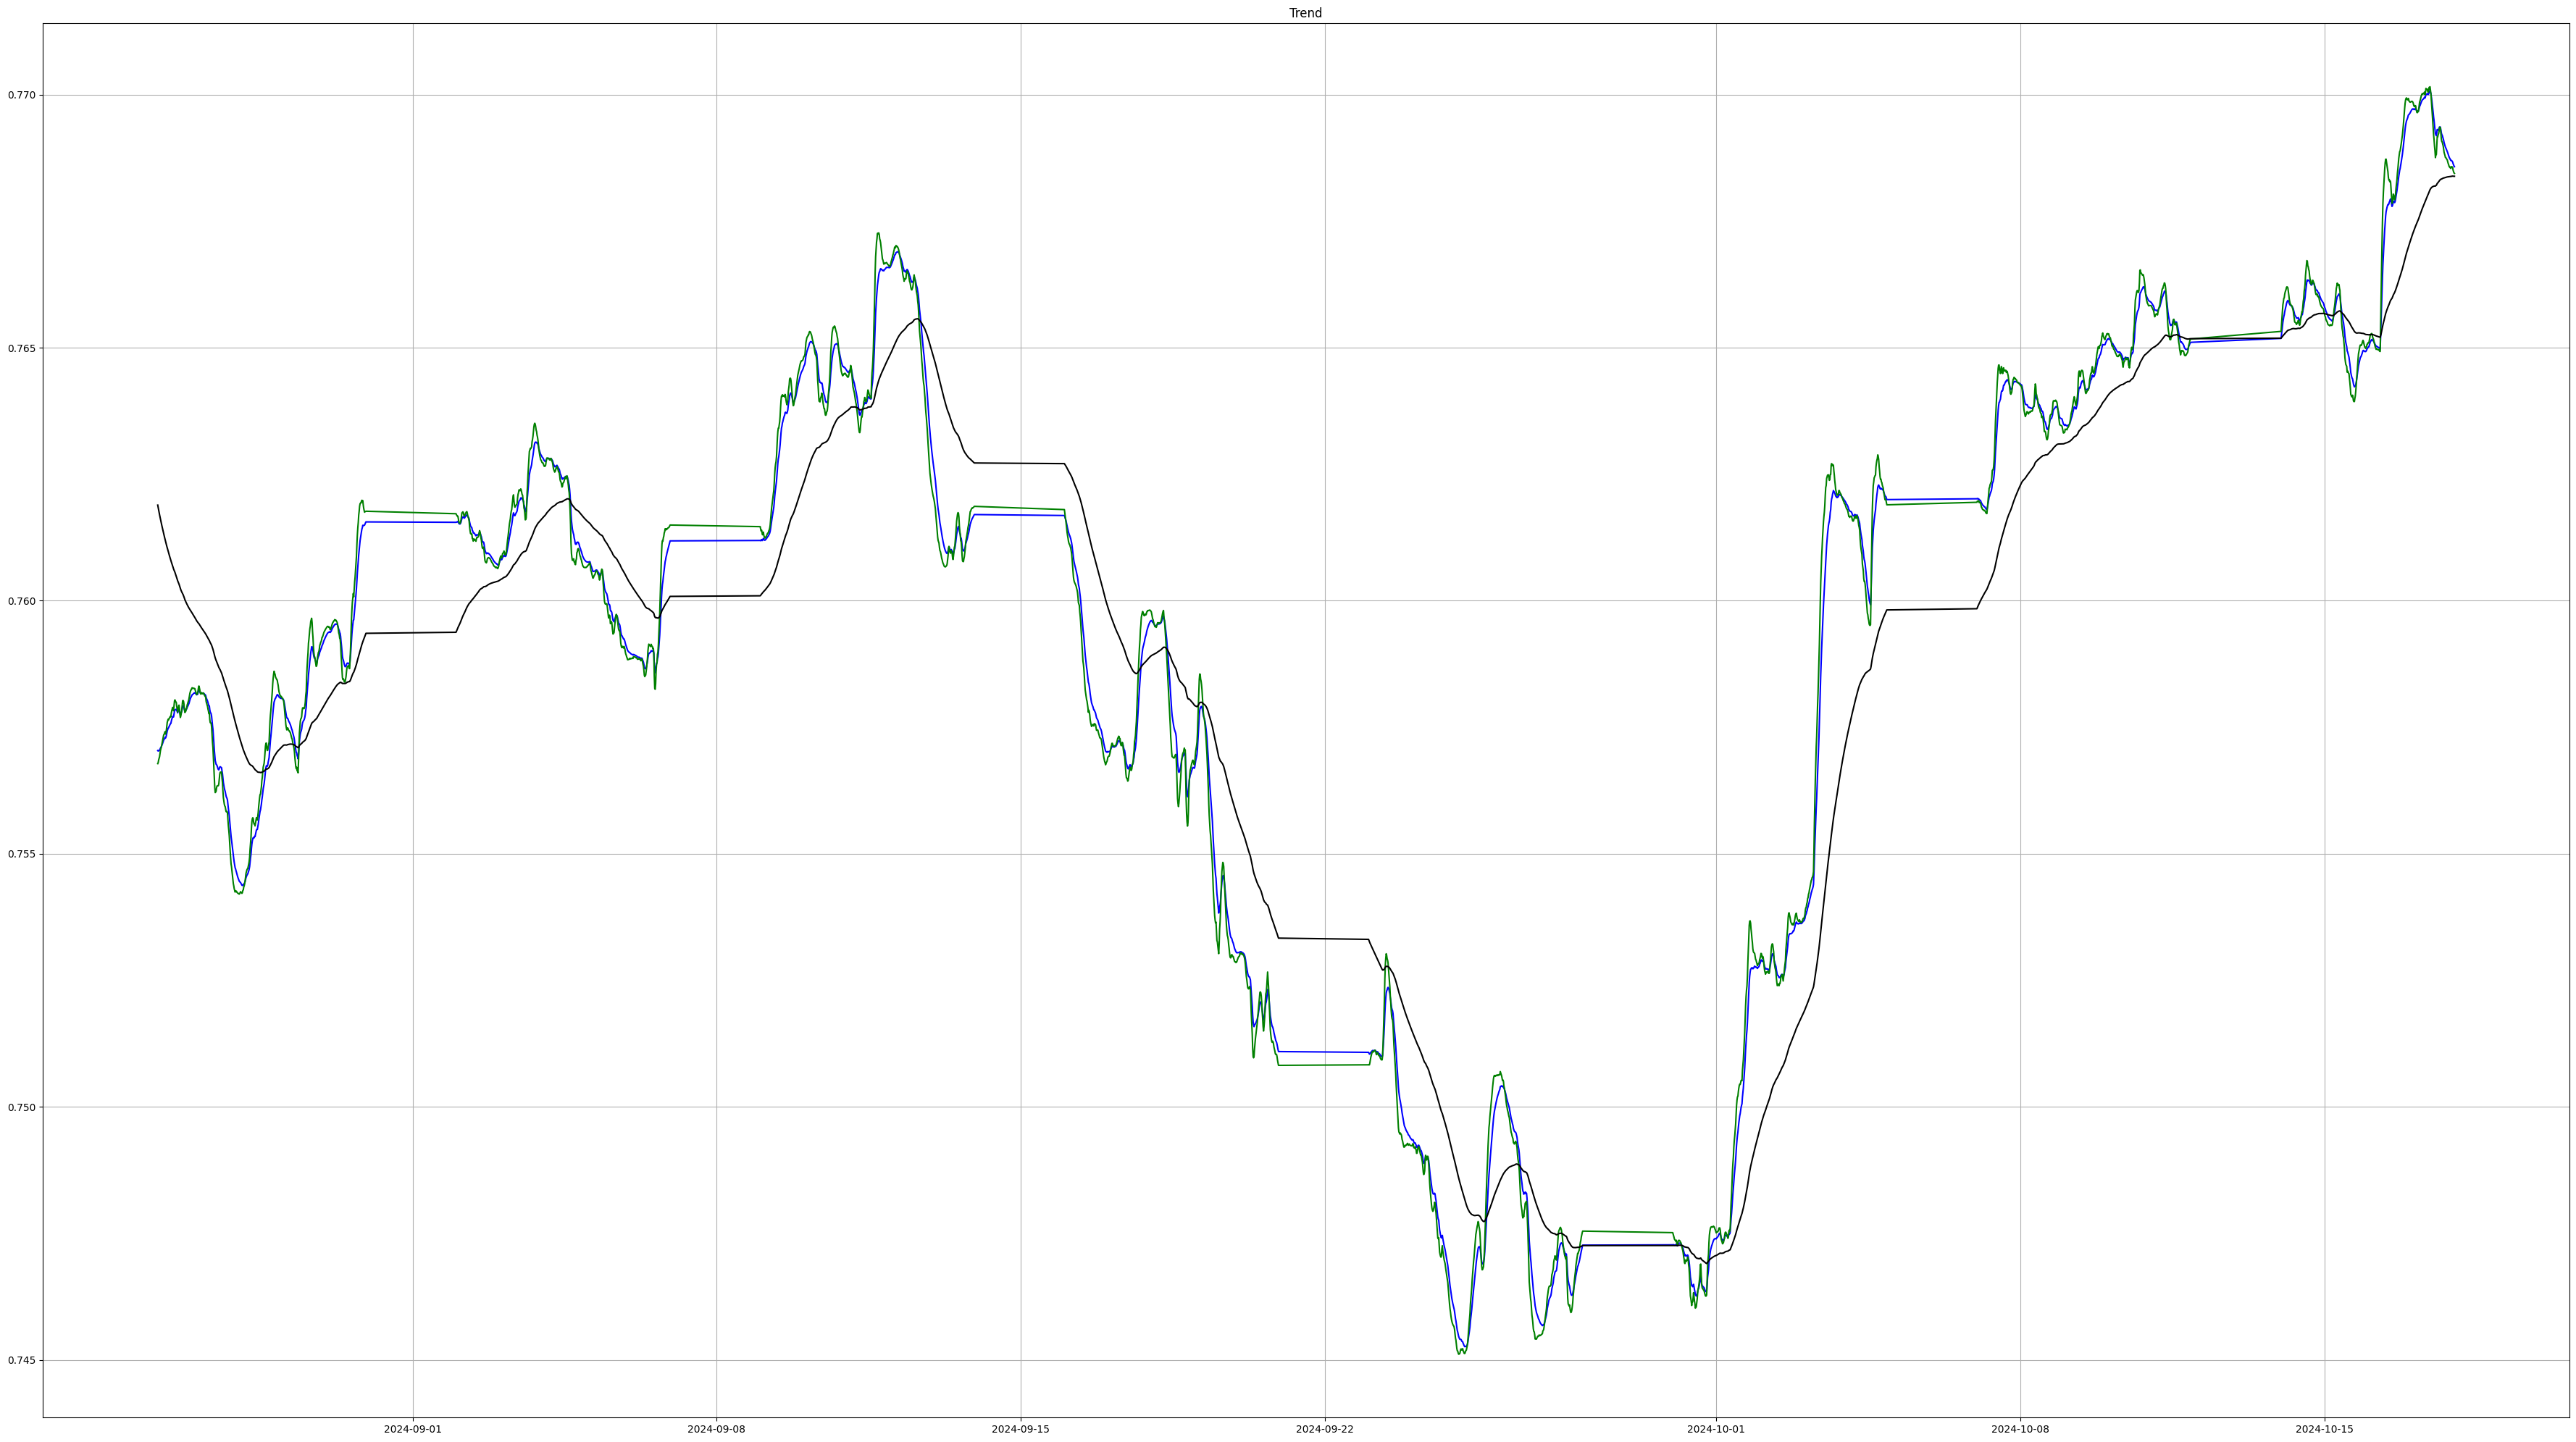

In [833]:
emaCrossover = EMACrossoverLongStrategy(data=data)
emaCrossover.plot_indicators()

/var/folders/9x/c8rnngl93m162n92399m4b6w0000gn/T/ipykernel_99490/4090497083.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['Signal'] = 0


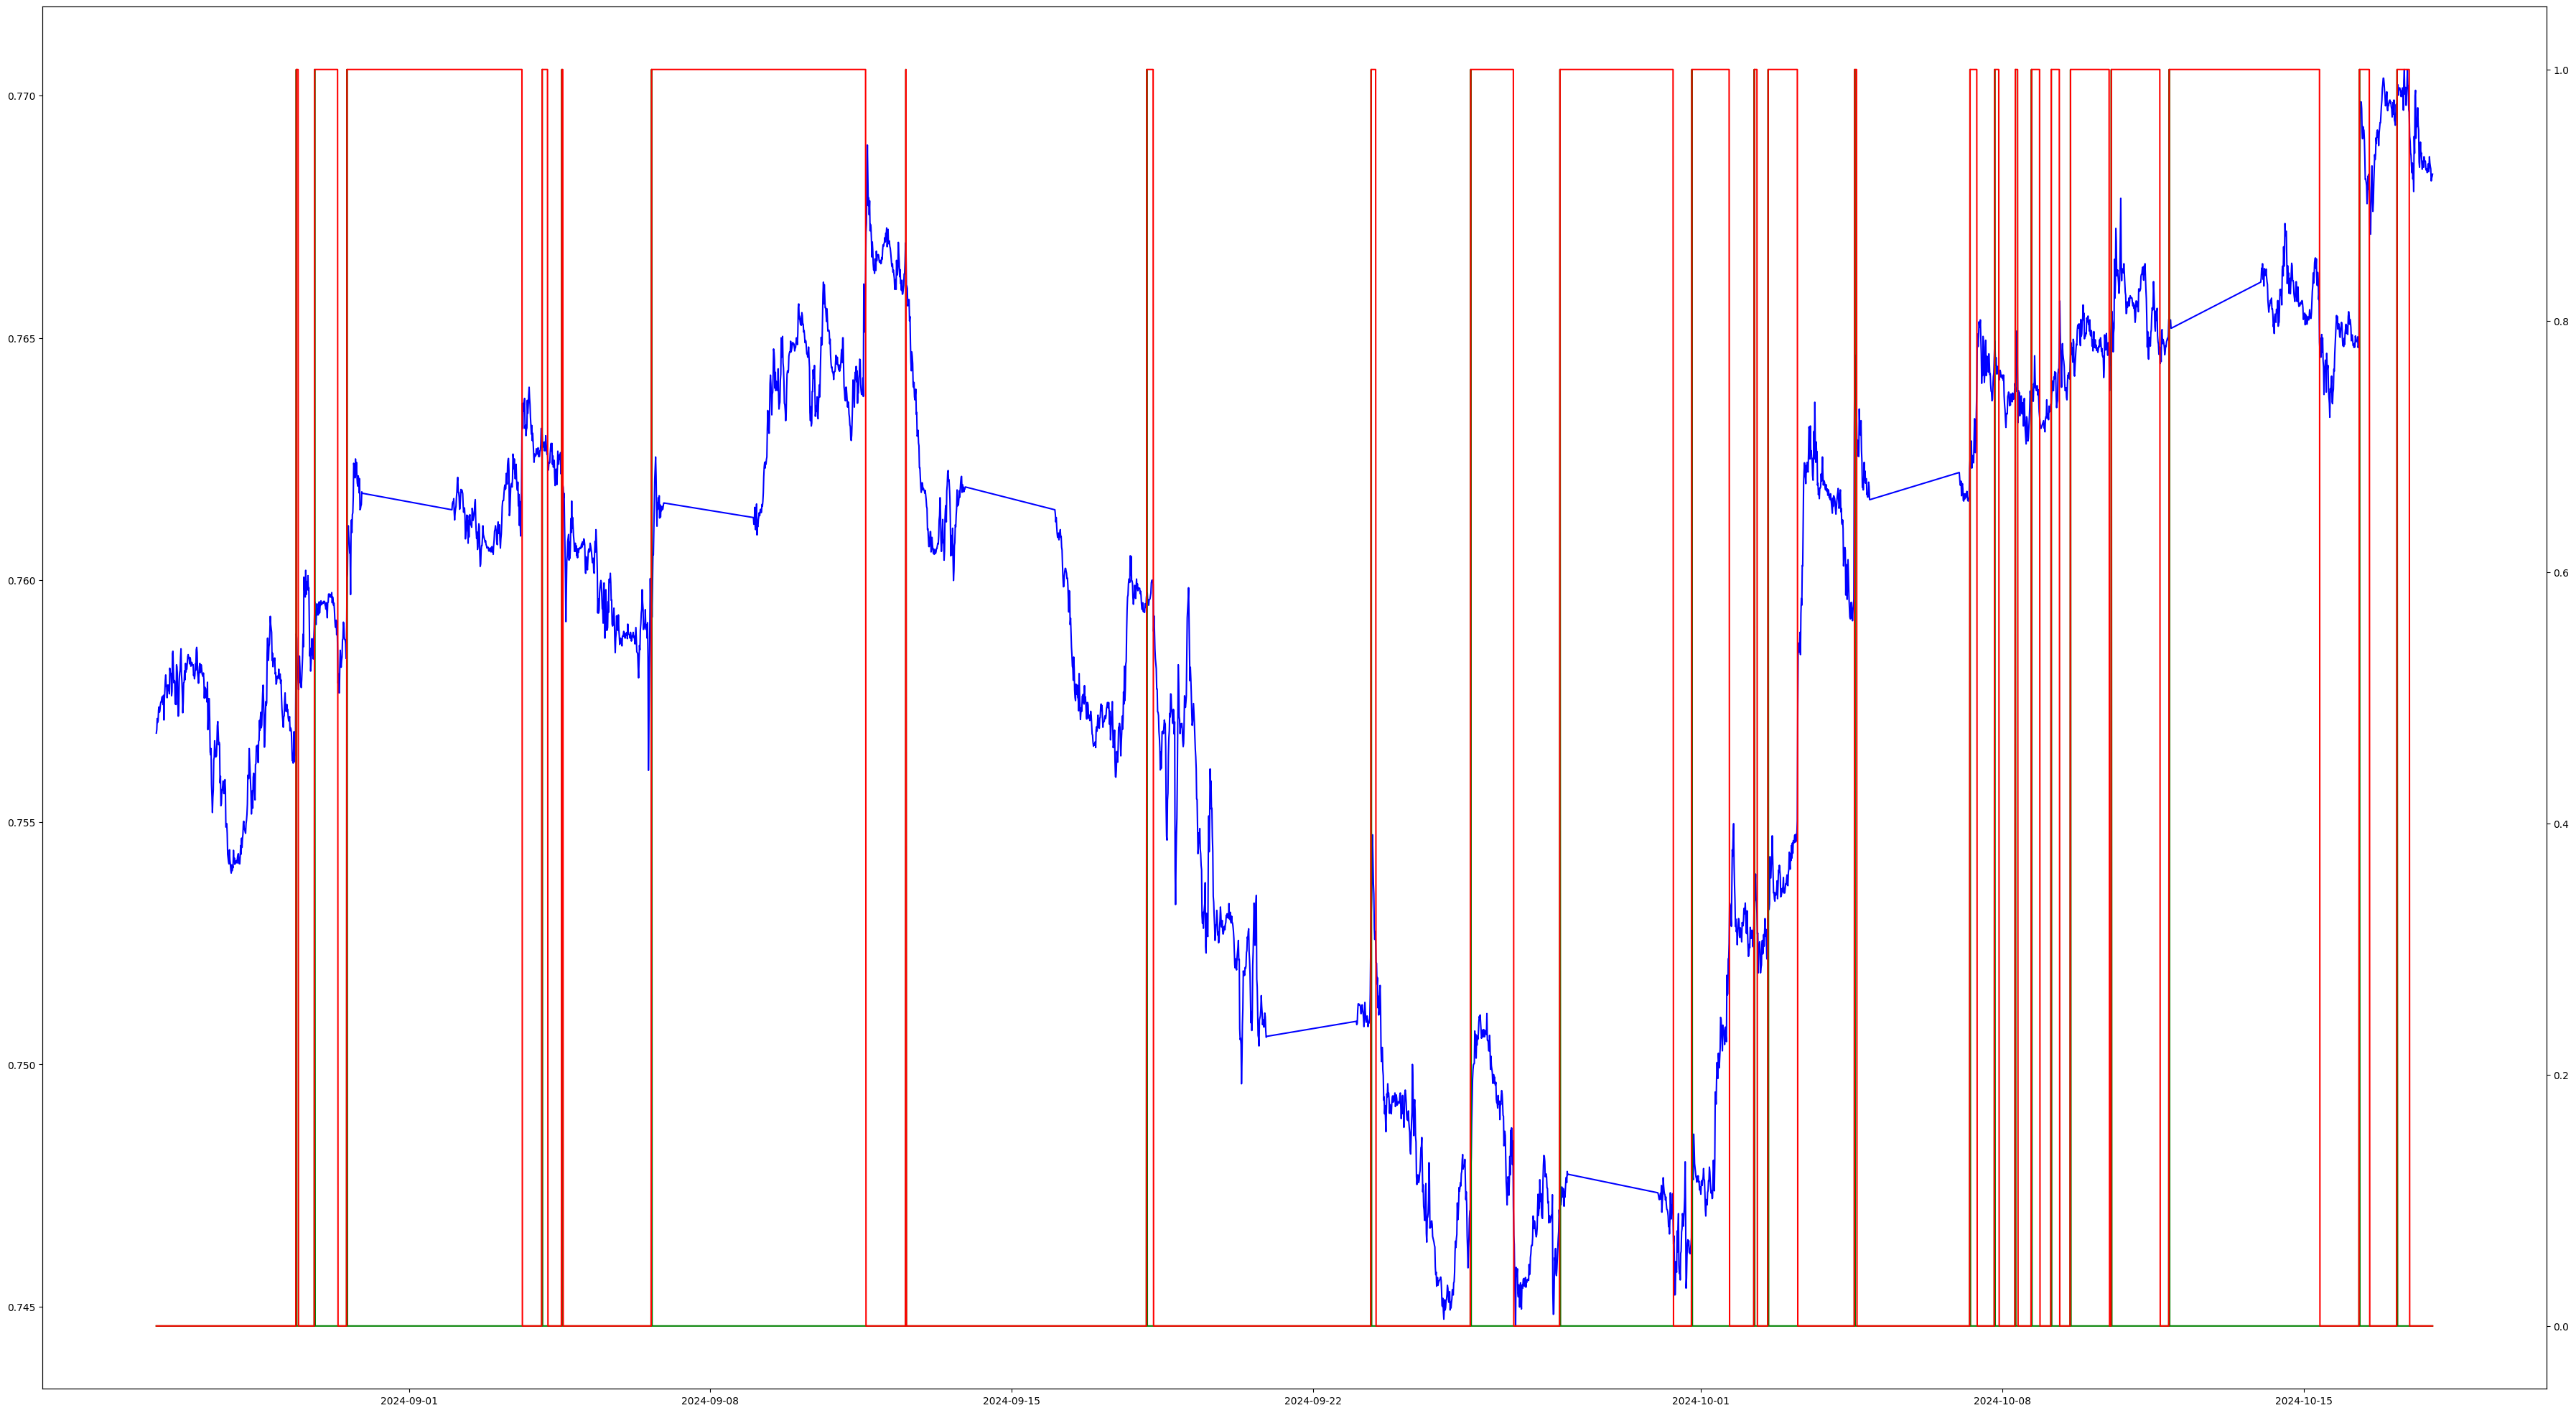

In [834]:
emaCrossover.implement()
emaCrossover.plot_positions()

/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.99' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.data.at[i, 'Cumulative Strategy Returns'] = cash


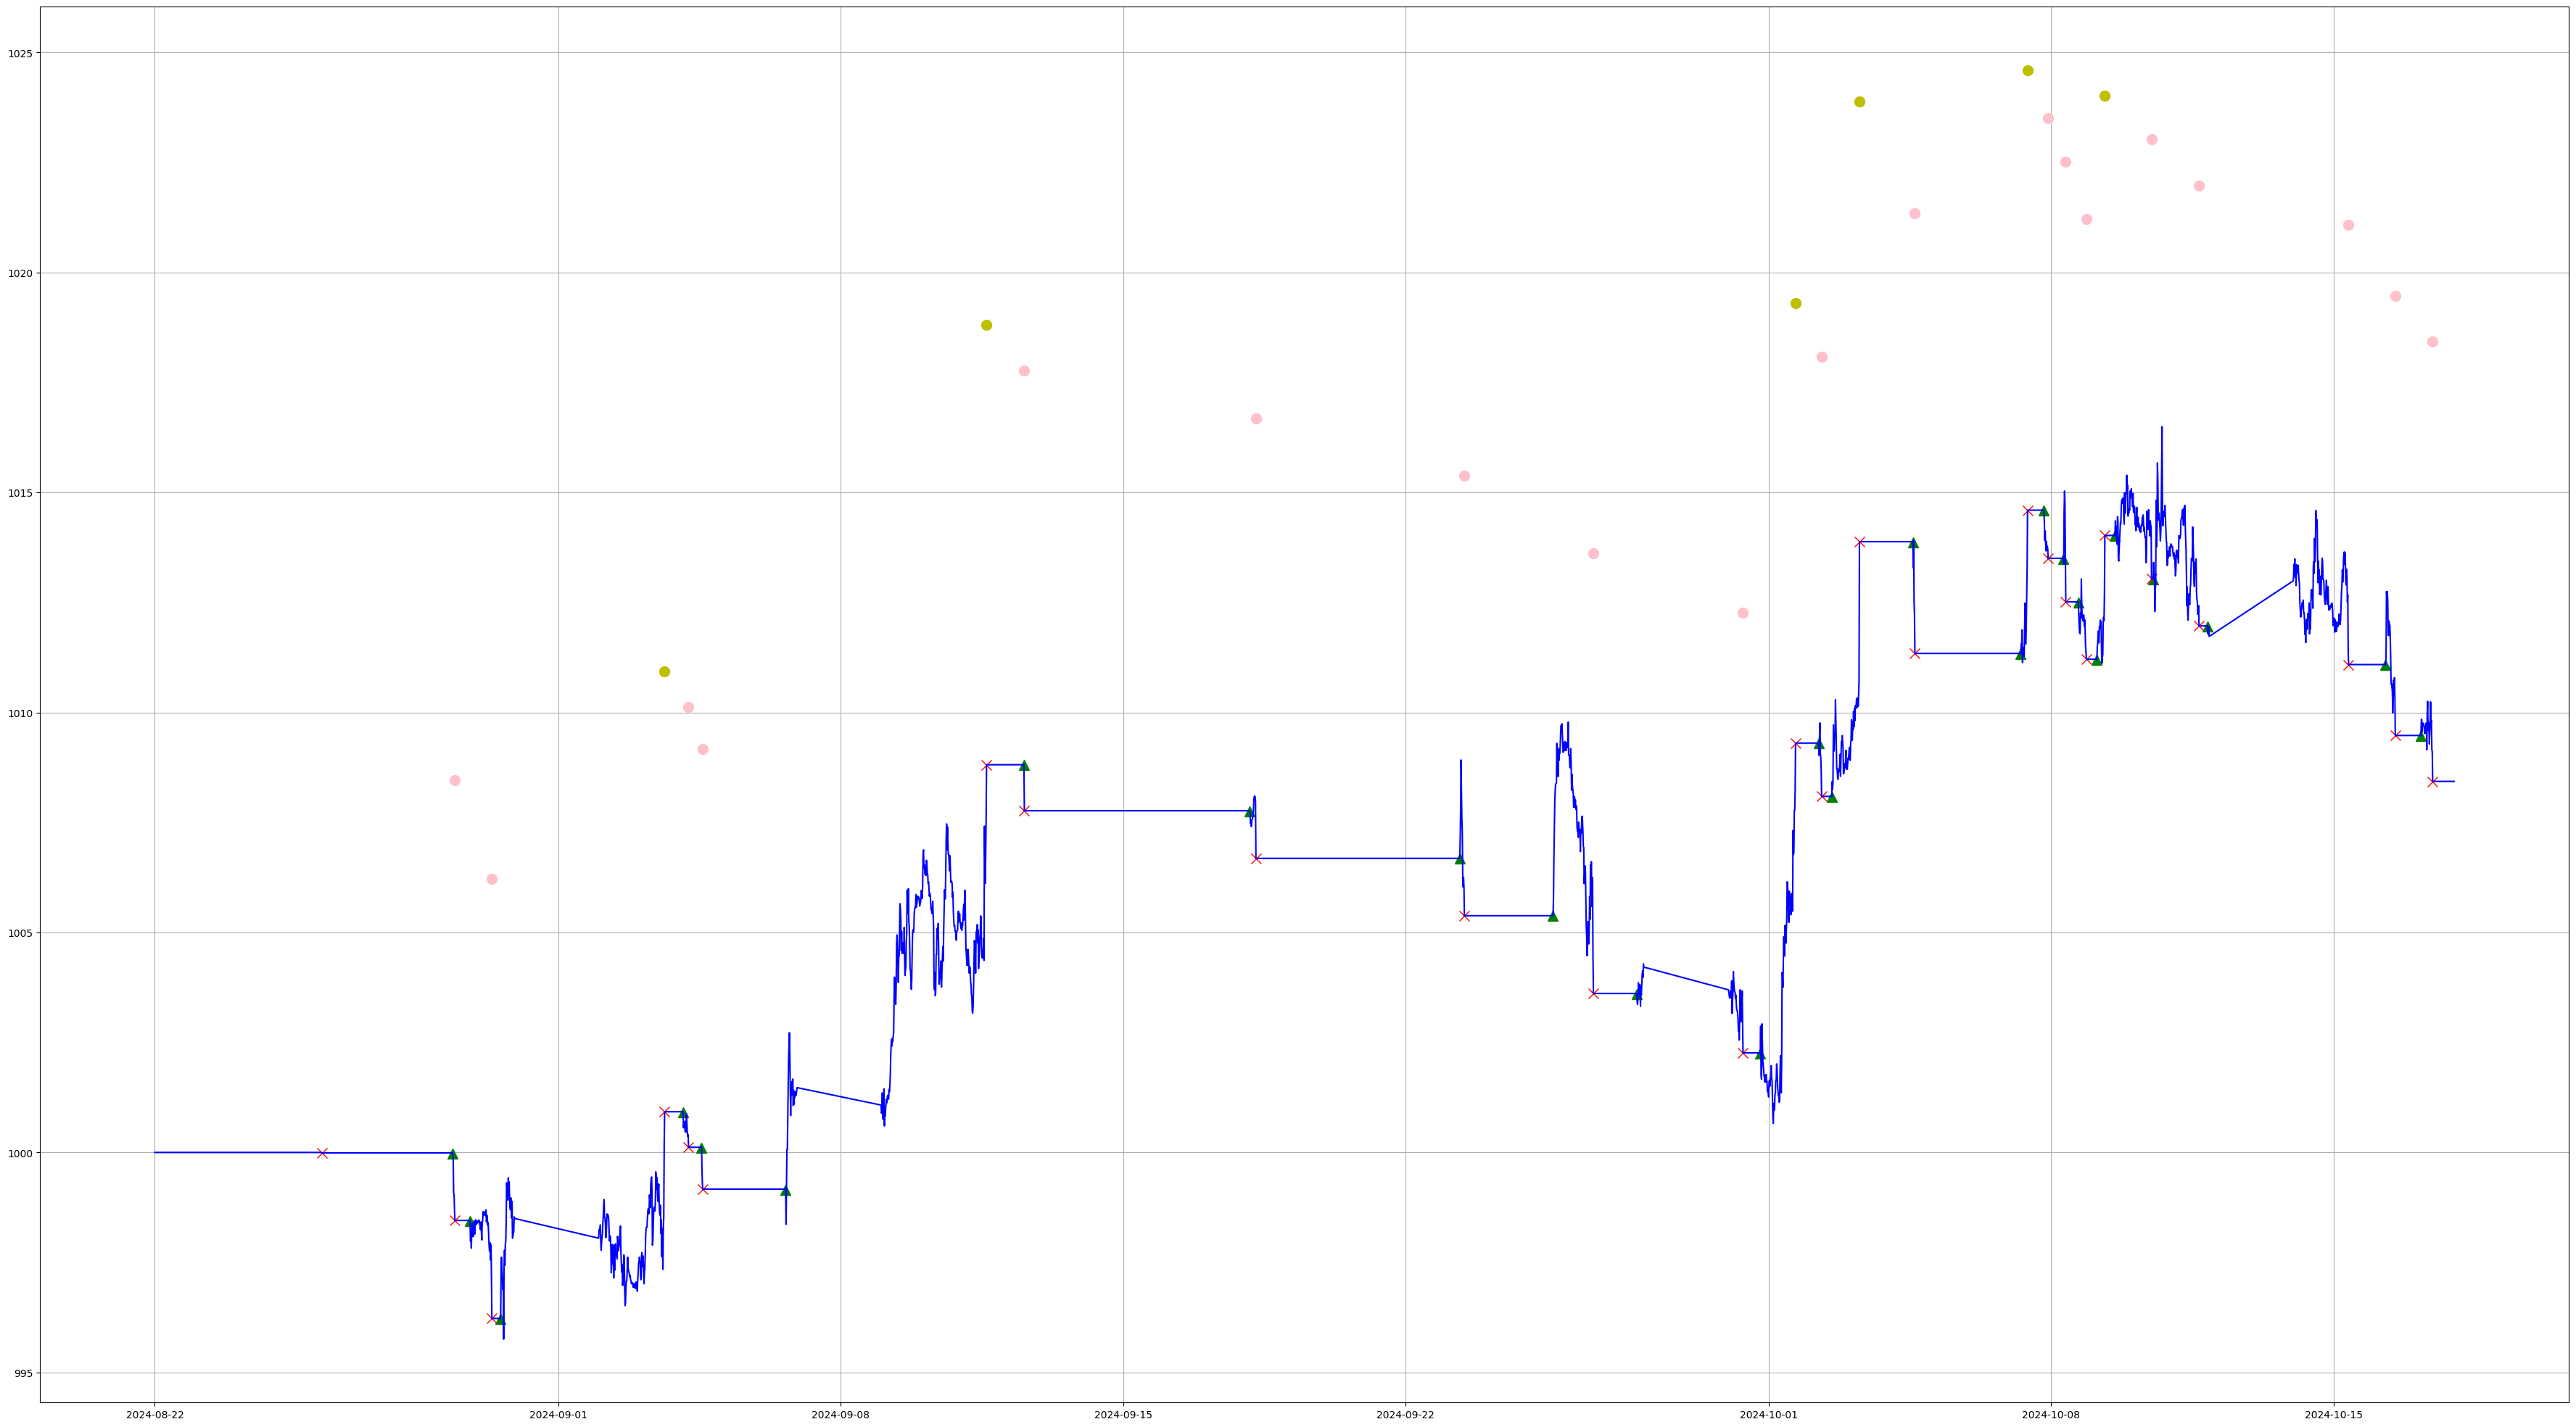

In [835]:
from backtester.backtester import Backtester


backtester = Backtester(emaCrossover, data, trade_commission=commission_percentage, amount_invested=amount_invested, leverage_ratio=leverage)
backtester.backtest()
backtester.plot_backtest()

In [836]:
backtester.get_metrics()

Final value:  1008.4336815955984
P&L:  8.433681595598387
Returns %:  0.8433681595598387
Number of trades:  25
Loss trades %:  76.0
Profit trades %:  24.0
Annual Sharpe ratio:  1.4390209827450293
Max profit %:  1.6492325708643307
Max loss %:  -0.42422630623692614


/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Final value: ', self.data['Cumulative Strategy Returns'][-1])
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('P&L: ', (self.data['Cumulative Strategy Returns'][-1] - (self.leverage_ratio*self.amount_invested)))
/Users/snehil1998/Documents/Repos/trading-strategies/backtester/backtester.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys